# Question 2

In [124]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import random
from random import randrange
import seaborn as sns

In [125]:
# Handling dataset: open, split
grid_data = pd.read_csv('dataset.csv')
grid_data_arr = np.array(grid_data)

grid_data_x = grid_data_arr[:,:-1]
grid_data_y = grid_data_arr[:, -1]

no_of_instances = len(grid_data_arr)

test_validation_size = int(no_of_instances * 0.3)
train_size = no_of_instances - test_validation_size

validation_size = int(test_validation_size * 1/3)
test_size = test_validation_size - validation_size

train_x = grid_data_x[:train_size]
train_y = grid_data_y[:train_size]

test_x = grid_data_x[train_size:train_size + test_size]
test_y = grid_data_y[train_size:train_size + test_size]

validation_x = grid_data_x[train_size + test_size:]
validation_y = grid_data_y[train_size + test_size:]

print(len(train_x), len(validation_x), len(test_x))

42000 6000 12000


In [126]:
# Normalizing the data
mins = []
maxs = []
for i in range(train_x.shape[1]):
    maxs.append(train_x[:, i].max())
    mins.append(train_x[:, i].min())

for i in range(train_x.shape[1]):
    train_x[:, i] = (train_x[:, i] - mins[i]) / (maxs[i] - mins[i])
    validation_x[:, i] = (validation_x[:, i] - mins[i]) / (maxs[i] - mins[i])
    test_x[:, i] = (test_x[:, i] - mins[i]) / (maxs[i] - mins[i])

In [143]:
def logistic_with_full_batch_gradient(x_train, x_test, y_train, learning_rate, init_type, find_acc, y_validation):
    
    def py0(sum_wi_dot_xi):
        return 1/(1 + np.exp(sum_wi_dot_xi))

    def py1(sum_wi_dot_xi):
        return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))

    def init_w():
        if init_type == "NORMAL":
            return (np.random.normal(loc=0, scale=1, size=x_train.shape[1]))
        elif init_type == "UNIFORM":
            return (np.random.uniform(size=x_train.shape[1]))
        else: # init with zeros
            return (np.zeros(x_train.shape[1]))
    
    def update_weight(w, x, y, a):
        total = np.zeros(x.shape[1])
        for index in range(len(y)):
            total += x[index] * (y[index] - py1(np.dot(x[index], w)))
        return w + a * total
    
    def fit(x, y, a):
        w = init_w()
        for epoch in range(100):
            w = update_weight(w, x, y, a)
        return w
    
    def transform(x, w):
        predictions = []
        for predict in x:
            predictions.append(0 if py0(np.dot(predict, w)) >= py1(np.dot(predict, w)) else 1)
        return predictions
    
    if find_acc == True:
        w = init_w()
        accuracies = []
        for epoch in range(100):
            w = update_weight(w, x_train, y_train, learning_rate)
            preds = transform(x_test, w)
            correct = 0
            for i in range(len(y_validation)):
                if preds[i] == y_validation[i]:
                    correct += 1
            accuracies.append(correct/len(y_validation))
        return accuracies
    else:
        w_trained = fit(x_train, y_train, learning_rate)
        return transform(x_test, w_trained) 

In [144]:
def logistic_with_stochastic_gradient(x_train, x_test, y_train, learning_rate, init_type, find_acc, y_validation):
    
    def py0(sum_wi_dot_xi):
        return 1/(1 + np.exp(sum_wi_dot_xi))

    def py1(sum_wi_dot_xi):
        return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))
    
    def init_w():
        if init_type == "NORMAL":
            return (np.random.normal(loc=0, scale=1, size=x_train.shape[1]))
        elif init_type == "UNIFORM":
            return (np.random.uniform(size=x_train.shape[1]))
        else: 
            return (np.zeros(x_train.shape[1]))
        
    def fit(x, y, a):
        w = init_w()
        for epoch in range(100):
            index = random.randint(0, len(y))
            w = w + a * (x[index] * (y[index] - py1(np.dot(x[index], w))))
        return w
    
    def transform(x, w):
        predictions = []
        for predict in x:
            predictions.append(0 if py0(np.dot(predict, w)) >= py1(np.dot(predict, w)) else 1)
        return predictions
    
    if find_acc:
        w = init_w()
        accuracies = []
        for epoch in range(100):
            index = random.randint(0, len(y_train))
            w = w + learning_rate * (x_train[index] * (y_train[index] - py1(np.dot(x_train[index], w))))
            preds = transform(x_test, w)
            correct = 0
            for i in range(len(y_validation)):
                if preds[i] == y_validation[i]:
                    correct += 1
            accuracies.append(correct/len(y_validation))
        return accuracies
    else:
        w_trained = fit(x_train, y_train, learning_rate)
        return transform(x_test, w_trained)

In [145]:
def logistic_with_mini_batch_gradient(x_train, x_test, y_train, learning_rate, batch_size, init_type, find_acc, y_validation):
    
    def py0(sum_wi_dot_xi):
        return 1/(1 + np.exp(sum_wi_dot_xi))

    def py1(sum_wi_dot_xi):
        return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))

    def init_w():
        if init_type == "NORMAL":
            return (np.random.normal(loc=0, scale=1, size=x_train.shape[1]))
        elif init_type == "UNIFORM":
            return (np.random.uniform(size=x_train.shape[1]))
        else: 
            return (np.zeros(x_train.shape[1]))
        
    def update_weight(w, x, y, a, batch_indices):
        total = np.zeros(w.shape)
        for index in batch_indices:
            total += x[index] * (y[index] - py1(np.dot(x[index], w)))
        return w + a * total
    
    def fit(x, y, a):
        w = init_w()
        for epoch in range(100):
            batch_indices = random.sample(range(0, len(y)), batch_size)
            w = update_weight(w, x, y, a, batch_indices)
        return w
    
    def transform(x, w):
        predictions = []
        for predict in x:
            predictions.append(0 if py0(np.dot(predict, w)) >= py1(np.dot(predict, w)) else 1)
        return predictions
    
    if find_acc:
        w = init_w()
        accuracies = []
        for epoch in range(100):
            batch_indices = random.sample(range(0, len(y_train)), batch_size)
            w = update_weight(w, x_train, y_train, learning_rate, batch_indices)
            preds = transform(x_test, w)
            correct = 0
            for i in range(len(y_validation)):
                if preds[i] == y_validation[i]:
                    correct += 1
            accuracies.append(correct/len(y_validation))
        return accuracies
    else:
        w_trained = fit(x_train, y_train, learning_rate)
        return transform(x_test, w_trained)

In [131]:
# Performance Metrics
def performance_metrics(predicted_y, actual_y):
    actual = pd.Series(actual_y, name='Actual').astype("int")
    predicted = pd.Series(predicted_y, name='Predicted')
    
    confusion_matrix = pd.crosstab(actual, predicted)
    tn, fp, fn, tp = confusion_matrix[0][0], confusion_matrix[1][0], confusion_matrix[0][1], confusion_matrix[1][1]
    
    precision = ((tp)/(tp + fp) if (tp + fp != 0) else 0)
    recall = ((tp)/(tp + fn) if (tp + fn != 0) else 0)
    
    def fb_score(p, r, b):
        return (1 + b**2)*(p * r)/((b**2 * p + r)) if p + r != 0 else 0
        
    
    print("Accuracy: ", (tn + tp)/(tn + fp + fn + tp))
    print("Label 0: Accuracy", ((tn)/(tn + fp) if (tn + fp != 0) else 0))
    print("Label 1 Accuracy: ", ((tp)/(tp + fn) if (tp + fn != 0) else 0))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", fb_score(precision, recall, 1))
    print("F2: ", fb_score(precision, recall, 2))
    print("F0.5: ", fb_score(precision, recall, 0.5))
    print("FPR: ", ((fp)/(fp + tn) if (fp + tn != 0) else 0))
    fig = plt.figure(figsize=(8,5))
    sns.set(font_scale=1.25)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='magma_r')

In [132]:
accs_fb = logistic_with_full_batch_gradient(train_x, validation_x, train_y, 1, "NORMAL", True, validation_y)
accs_mb = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 1, 64, "NORMAL", True, validation_y)
accs_s = logistic_with_stochastic_gradient(train_x, validation_x, train_y, 1, "NORMAL", True, validation_y)

<ipython-input-114-c2fa7a87cb29>:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(sum_wi_dot_xi))
<ipython-input-114-c2fa7a87cb29>:7: RuntimeWarning: overflow encountered in exp
  return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))
<ipython-input-114-c2fa7a87cb29>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))


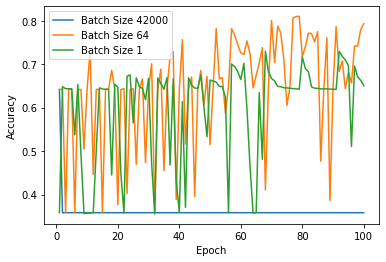

In [133]:
y_axis = list(np.arange(1,101))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(y_axis, accs_fb,  label = "Batch Size 42000")
plt.plot(y_axis, accs_mb,  label = "Batch Size 64")
plt.plot(y_axis, accs_s,  label = "Batch Size 1")
plt.legend()
plt.show()

In [134]:
accs_fb = logistic_with_full_batch_gradient(train_x, validation_x, train_y, 0.01, "NORMAL", True, validation_y)
accs_mb = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "NORMAL", True, validation_y)
accs_s = logistic_with_stochastic_gradient(train_x, validation_x, train_y, 0.01, "NORMAL", True, validation_y)

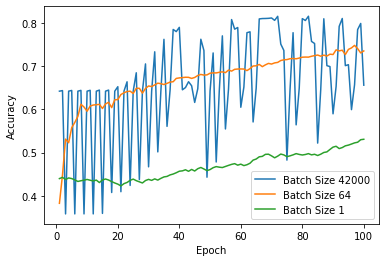

In [135]:
y_axis = list(np.arange(1,101))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(y_axis, accs_fb,  label = "Batch Size 42000")
plt.plot(y_axis, accs_mb,  label = "Batch Size 64")
plt.plot(y_axis, accs_s,  label = "Batch Size 1")
plt.legend()
plt.show()

Accuracy:  0.7193333333333334
Label 0: Accuracy 0.9402752531809919
Label 1 Accuracy:  0.32340623545835273
Precision:  0.7513513513513513
Recall:  0.32340623545835273
F1:  0.45217957059206243
F2:  0.36498266988761685
F0.5:  0.5941186527611557
FPR:  0.05972474681900805


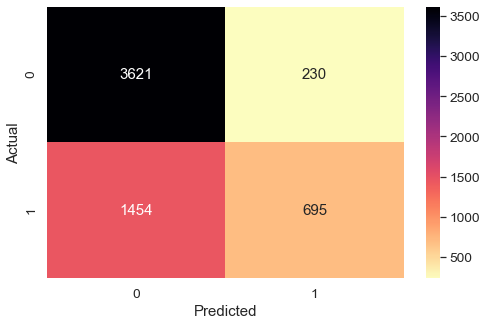

In [137]:
predictions_mb = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "NORMAL", False, validation_y)
performance_metrics(predictions_mb, validation_y)

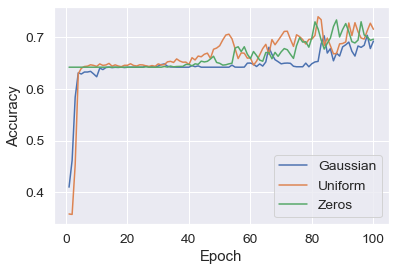

In [161]:
acc_normal = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "NORMAL", True, validation_y)
acc_uniform = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "UNIFORM", True, validation_y)
acc_zero = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "ZERO", True, validation_y)

y_axis = list(np.arange(1,101))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(y_axis, acc_normal,  label = "Gaussian")
plt.plot(y_axis, acc_uniform,  label = "Uniform")
plt.plot(y_axis, acc_zero,  label = "Zeros")
plt.legend()
plt.show()

Accuracy:  0.7233333333333334
Label 0: Accuracy 0.9872760321994287
Label 1 Accuracy:  0.25034899953466727
Precision:  0.9165247018739353
Recall:  0.25034899953466727
F1:  0.3932748538011696
F2:  0.2929325928345856
F0.5:  0.5981765621525461
FPR:  0.01272396780057128


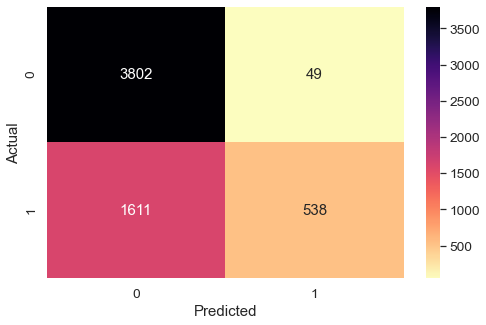

In [164]:
predictions_mb = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 0.01, 64, "UNIFORM", False, validation_y)
performance_metrics(predictions_mb, validation_y)

In [174]:
learning_rates = [1, 10**-3, 10**-4, 10**-5]

accuracies_learning_rates = []
for learning_rate in learning_rates:
    accuracies_learning_rates.append(logistic_with_mini_batch_gradient(train_x, validation_x, train_y, learning_rate, 64, "NORMAL", True, validation_y))

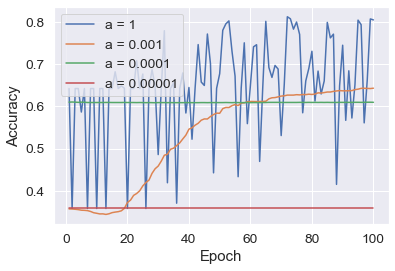

In [175]:
y_axis = list(np.arange(1,101))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(y_axis, accuracies_learning_rates[0],  label = "a = 1")
plt.plot(y_axis, accuracies_learning_rates[1],  label = "a = 0.001")
plt.plot(y_axis, accuracies_learning_rates[2],  label = "a = 0.0001")
plt.plot(y_axis, accuracies_learning_rates[3],  label = "a = 0.00001")
plt.legend()
plt.show()

In [168]:
accuracies_learning_rates = []
for learning_rate in learning_rates:
    accuracies_learning_rates.append(logistic_with_full_batch_gradient(train_x, validation_x, train_y, learning_rate, "NORMAL", True, validation_y))

<ipython-input-143-50bf92ea0311>:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(sum_wi_dot_xi))
<ipython-input-143-50bf92ea0311>:7: RuntimeWarning: overflow encountered in exp
  return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))
<ipython-input-143-50bf92ea0311>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(sum_wi_dot_xi)) / (1 + np.exp(sum_wi_dot_xi))


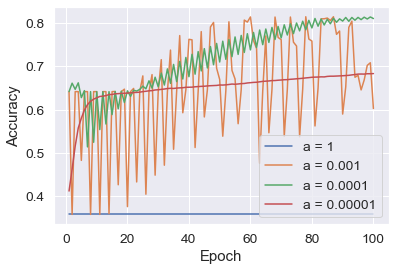

In [169]:
y_axis = list(np.arange(1,101))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(y_axis, accuracies_learning_rates[0],  label = "a = 1")
plt.plot(y_axis, accuracies_learning_rates[1],  label = "a = 0.001")
plt.plot(y_axis, accuracies_learning_rates[2],  label = "a = 0.0001")
plt.plot(y_axis, accuracies_learning_rates[3],  label = "a = 0.00001")
plt.legend()
plt.show()

Accuracy:  0.8138333333333333
Label 0: Accuracy 0.8911970916645027
Label 1 Accuracy:  0.6751977664029781
Precision:  0.7759358288770053
Recall:  0.6751977664029781
F1:  0.7220701667081362
F2:  0.6931970189184024
F0.5:  0.7534531103956796
FPR:  0.10880290833549727
Accuracy:  0.8023333333333333
Label 0: Accuracy 0.9439106725525838
Label 1 Accuracy:  0.5486272684969753
Precision:  0.8451612903225807
Recall:  0.5486272684969753
F1:  0.6653498871331829
F2:  0.5900310279251325
F0.5:  0.7627118644067796
FPR:  0.05608932744741626


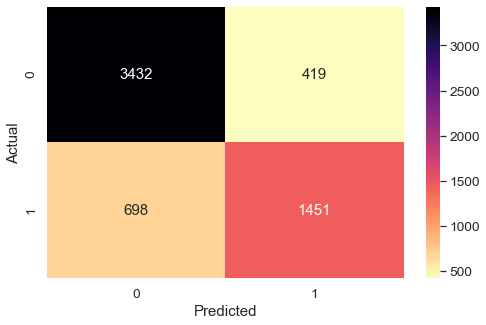

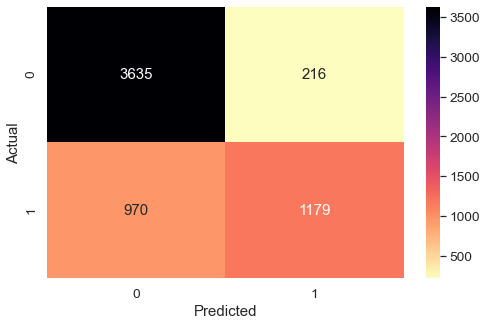

In [177]:
pred_fb = logistic_with_full_batch_gradient(train_x, validation_x, train_y, 10**-4,  "NORMAL", False, validation_y)
pred_mb = logistic_with_mini_batch_gradient(train_x, validation_x, train_y, 1, 64,  "NORMAL", False, validation_y)

performance_metrics(pred_fb, validation_y)
performance_metrics(pred_mb, validation_y)

Accuracy:  0.6388333333333334
Label 0: Accuracy 0.9998692126602144
Label 1 Accuracy:  0.00482315112540193
Precision:  0.9545454545454546
Recall:  0.00482315112540193
F1:  0.009597806215722121
F2:  0.006021332721642391
F0.5:  0.02363800090049527
FPR:  0.00013078733978550875


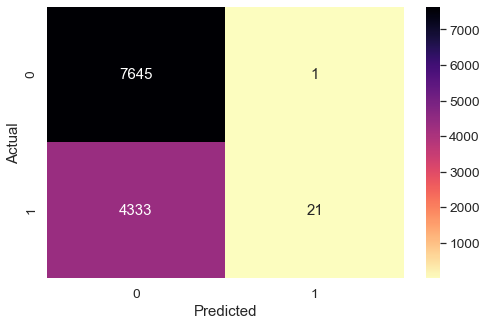

In [182]:
pred_mb_opt = logistic_with_mini_batch_gradient(train_x, test_x, train_y, 10**-3, 64,  "UNIFORM", False, test_y)

performance_metrics(pred_mb_opt, test_y)

Accuracy:  0.8139166666666666
Label 0: Accuracy 0.8750980905048391
Label 1 Accuracy:  0.7064768029398254
Precision:  0.7630860828578516
Recall:  0.7064768029398254
F1:  0.7336911150864639
F2:  0.7171166130461137
F0.5:  0.7510499072175018
FPR:  0.12490190949516086


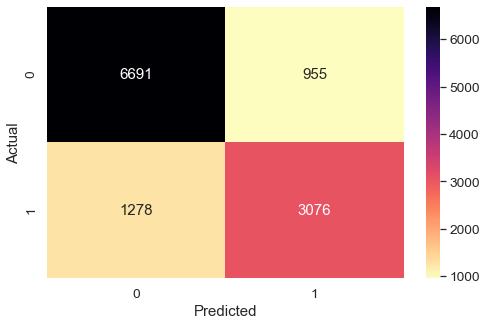

In [188]:
pred_mb_opt = logistic_with_mini_batch_gradient(train_x, test_x, train_y, 1, 64,  "UNIFORM", False, test_y)

performance_metrics(pred_mb_opt, test_y)

Accuracy:  0.8156666666666667
Label 0: Accuracy 0.8927543813758828
Label 1 Accuracy:  0.6802939825447865
Precision:  0.7831835007932311
Recall:  0.6802939825447865
F1:  0.7281219272369714
F2:  0.6986508161147278
F0.5:  0.7601888923108511
FPR:  0.10724561862411719


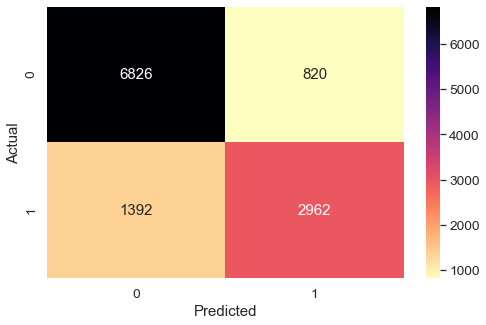

In [190]:
pred_fb_opt = logistic_with_full_batch_gradient(train_x, test_x, train_y, 10**-4, "UNIFORM", False, test_y)

performance_metrics(pred_fb_opt, test_y)